# Create Database
This jupyter notebook is fore creating the base db for the SF Parking EDA. There are 2 data sources we'll process in this book. 
1. Parking Ticket Data (csv)
2. Address Data (csv)


The goal is to process the raw data and create a relational database so we can do some more exploratory analysis. 

In [1]:
import sqlite3
import pandas as pd
import datetime as dt
import geopandas as gpd
import glob
import time
import re
from geopy.geocoders import Nominatim
from tqdm import tqdm
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import math
%matplotlib inline
raw_folder = '/home/colin/Desktop/SF_Parking/data/raw/'
proc_folder = '/home/colin/Desktop/SF_Parking/data/processed/'

try:
    os.rename('SF_Parking.db', 'SF_Parking_Backup.db')
except: 
    pass

try:
    os.remove('SF_Parking.db')
except: 
    pass
    

In [2]:
disk_engine = create_engine('sqlite:///SF_Parking.db')
conn = sqlite3.connect('SF_Parking.db')
c = conn.cursor()

# Raw Ticket Data
Here we'll simply load all the csv data into a raw ticket database

In [3]:
#function to return queries into DF
def result_query(querystring):
    resultdf = pd.read_sql(sql= querystring, con = conn)
    
    return resultdf

In [4]:
#loop through all files and create dataframe, insert into db
#c.execute('Drop table raw_ticket_data')
start = dt.datetime.now()
for csv_file in glob.glob(raw_folder + "/ticket_data/PRR_*"):
    index_start = 1
    j = 0
    print('{} file started at {}'.format(csv_file, dt.datetime.now()))    
    df = pd.read_csv(csv_file, encoding = 'utf-8', parse_dates = ['Tick Issue Date'])       
    df = df.rename(columns = {c: c.replace(' ', '') for c in df.columns})
    try:
        df.to_sql('raw_ticket_data', conn, if_exists='append')
    except:
        print('File read error')
       
    
    print ('{} file finished in {:03.2f} minutes '.format(csv_file, (dt.datetime.now()-start).seconds / 60))

/home/colin/Desktop/SF_Parking/data/raw//ticket_data/PRR_P000731_082418_070118_to_083118.csv file started at 2018-10-30 17:41:48.394829
/home/colin/Desktop/SF_Parking/data/raw//ticket_data/PRR_P000731_082418_070118_to_083118.csv file finished in 0.32 minutes 
/home/colin/Desktop/SF_Parking/data/raw//ticket_data/PRR_P000731_082418_070116_to_123116.csv file started at 2018-10-30 17:42:07.512372
/home/colin/Desktop/SF_Parking/data/raw//ticket_data/PRR_P000731_082418_070116_to_123116.csv file finished in 1.25 minutes 
/home/colin/Desktop/SF_Parking/data/raw//ticket_data/PRR_P000731_082418_010118_to_0630018.csv file started at 2018-10-30 17:43:03.828393


/home/colin/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


/home/colin/Desktop/SF_Parking/data/raw//ticket_data/PRR_P000731_082418_010118_to_0630018.csv file finished in 2.37 minutes 
/home/colin/Desktop/SF_Parking/data/raw//ticket_data/PRR_P000731_082418_010117_to_0630017.csv file started at 2018-10-30 17:44:10.910549
/home/colin/Desktop/SF_Parking/data/raw//ticket_data/PRR_P000731_082418_010117_to_0630017.csv file finished in 3.98 minutes 
/home/colin/Desktop/SF_Parking/data/raw//ticket_data/PRR_P000731_082418_070117_to_1231017.csv file started at 2018-10-30 17:45:48.015887
/home/colin/Desktop/SF_Parking/data/raw//ticket_data/PRR_P000731_082418_070117_to_1231017.csv file finished in 6.52 minutes 


# Initial Address Data
There are quite a lot of addresses missing so we'll have to do some cleaning, and generate some data of our own. 

In [5]:
#use our SF BLock Limits table to create a dictionary of dataframes for each street name. 
#We can use this to bounce against when we have a combination that doesnt match the raw address records
#We'll also create a dataframe of street intersections
columns_first = ['BlockStart', 'StreetName', 'Suffix']
columns_second = ['BlockEnd', 'Cross1', 'Cross2', 'numbers']
valid_suffix = ['ST', 'WY', 'DR', 'AV', 'LN', 'WAY', 'TER', 'PL', 'AVE']
streetnamedict = {}

with open(raw_folder + 'SF_Block_Limits_Table.txt') as f:
    lines = [line.rstrip('\n') for line in f]

streetintersections = pd.DataFrame(columns = ['Street', 'Suffix', 'Isection', 'Number'])
   
streetnamedict = {}
suffixnums = pd.DataFrame(columns = ['Suffix', 'Min', 'Max', 'Count'])
suffixnumsdefault = pd.DataFrame(columns = ['Suffix', 'Min', 'Max', 'Count'])
streetnamedict['NA'] = suffixnumsdefault
for idx, line in enumerate(lines):
    rowsplit = line.split()
    if len(rowsplit) == 5 and rowsplit[3] in valid_suffix:
        suffix = rowsplit[3]
        streetname = rowsplit[2]
        minnum = int(rowsplit[1])
        maxnum = int(lines[idx+1].split()[1])
        suffixnums = streetnamedict.get(streetname, suffixnumsdefault)
        totalsuffix = pd.DataFrame(columns = ['Suffix', 'Min', 'Max', 'Count'])
        #print(lines[idx+1])
        
        isections = str(lines[idx+1]).replace( '/', ' ').split()[3:5]
        dfrec1 = [streetname, streetname]
        dfrec2 = [suffix, suffix]
        dfrec3 = [isections[0], isections[1]]
        dfrec4 = [minnum, maxnum]
        newrecords = pd.DataFrame({'Street': dfrec1, 'Suffix': dfrec2, 'Isection': dfrec3, 'Number': dfrec4 })
        streetintersections = streetintersections.append(newrecords)
        
        if suffixnums.shape[0] > 0:
            suffixnumsame = suffixnums[suffixnums['Suffix'] == suffix]
            suffixnumother = suffixnums[suffixnums['Suffix'] != suffix]
            if suffixnumsame.shape[0] == 0:               
                suffixlist = [suffix, minnum, maxnum, 0]
                suffixnumsame.loc[0] = [value for value in suffixlist]

            elif suffixnumsame.shape[0] == 1:            
                if suffixnumsame['Max'][0] < maxnum:
                    suffixnumsame['Max'][0] = maxnum

                if suffixnumsame['Min'][0] > minnum:
                    suffixnumsame['Min'][0] = minnum

                suffixnumsame['Count'][0] += 1

            totalsuffix = suffixnumother.append(suffixnumsame)
        
        else:
           
            suffixlist = [suffix, minnum, maxnum, 0]           
            totalsuffix.loc[0] = [value for value in suffixlist]

        totalsuffix.reset_index()
        streetnamedict[streetname] = totalsuffix
streetintersections.drop_duplicates(subset = ['Street', 'Isection'], inplace = True)   
sqldf = streetintersections[['Number', 'Street']]

/home/colin/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
#create a function to map numbers with their full streetname 
replacements = ['[^0-9a-zA-Z\s]', '^0+']
streetnums = {'1':'ST', '2': 'ND', '3': 'RD', '4': 'TH', '5': 'TH', '6': 'TH', '7': 'TH', '8': 'TH', '9': 'TH', '0': 'TH'}
def replace_street(street):
    if isinstance(street, str):
        for rep in replacements:
            street = re.sub(rep, "", street)
    
    streetint = re.findall(r'\d+', str(street))
    if len(streetint) > 0 and int(streetint[0]) < 100:
        street = int(streetint[0])
        
        if street < 10:
            street = '0' + str(street) + str(streetnums[str(street)])
        elif street < 14:
            street = str(street) + 'TH'
        else:
            street = str(street) + str(streetnums[str(street)[-1]])

        
    return street


In [7]:
#read our address csv file into a df
addresses = pd.read_csv(raw_folder + '/san_francisco_addresses.csv')
addresses.columns = map(str.lower, addresses.columns)
addresses.columns

/home/colin/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['lon', 'lat', 'number', 'street', 'unit', 'city', 'district', 'region',
       'postcode', 'id', 'hash', 'unnamed: 11'],
      dtype='object')

In [8]:
#function to remove non number characters, 
def return_num(strnum):
    if strnum != strnum or strnum == ' ':
        return -1
    else:
        strnum = re.sub('[^1-9]', '', str(strnum))
        return int(strnum)
 

In [9]:
#Some streets have names like 'AVENUE A' we dont want to strip out, only remove the last suffix if in the list
valid_suffix = ['ST', 'WY', 'DR', 'AV', 'LN', 'WAY', 'TER', 'PL', 'BLVD', 'AVE']
def return_street(streetname):
    if streetname == None:
        return streetname
    if streetname.split(" ")[-1] in valid_suffix:
        return " ".join(str(streetname).split(" ")[:-1])
    
    return streetname


In [10]:
keepcolumns = ['lon', 'lat', 'number', 'street']
addresses = addresses[keepcolumns]
#Get rid of apartment number
addresses['number'] = addresses['number'].apply(lambda x: re.findall( '\d+', x)[0]).astype(int)

#combine into an address
addresses['address'] = addresses.apply(lambda x: str(x['number']) + " " + str(x['street']), axis = 1)

#return just streetname as its only columns, remove suffix
addresses['streetname'] = addresses['street'].apply(return_street)


In [11]:
addresses.drop_duplicates(subset = 'address', inplace = True)
addresses['type'] = 'known'
addresses.to_sql('raw_address_data', if_exists = 'replace', con = conn)
addresses.shape

(207698, 7)

In [12]:
#Let's look for all combinations that wont yield any matches 
df = result_query('Select distinct tickstreetno , tickstreetname , count(*) total_tickets from raw_ticket_data t1'
                      ' left join raw_address_data t2 on t1.TickStreetNo = t2.number and t1.TickStreetName = t2.streetname '
                      " where t2.address is null group by tickstreetno, tickstreetname ")
df.shape

(268998, 3)

In [13]:
#Assign a blocknumber to both known and unknown addresses

df['TickStreetNo'] = df['TickStreetNo'].apply(return_num)
df['TickStreetName'] = df['TickStreetName'].apply(replace_street)
df['TickStreetName'] = df['TickStreetName'].apply(return_street)
df['blocknum'] = df['TickStreetNo'].apply(lambda x: math.ceil(x/100))
df.drop_duplicates(inplace = True)

df2 = addresses
df2['blocknum'] = df2['number'].apply(lambda x: math.ceil(x/100))


In [14]:
#merge on same streetname, blocknumber, and side
newdf = df.merge(df2, how = 'left', left_on = ['TickStreetName', 'blocknum'], \
                 right_on = ['streetname', 'blocknum'])

In [15]:
#filter out those we couldnt find and save 
unfound = newdf[pd.isnull(newdf.number)]
unfound['type'] == "unknown"

#only include those we did, take the closest records coordinates, note we only drop on 'street' (street + suffix)
#and not streetname , so we'll keep both suffixes if valid
newdf = newdf[pd.isnull(newdf.number) == False]
newdf['delta'] = np.abs(newdf['number'] - newdf['TickStreetNo'])
newdf.sort_values(by = 'delta', inplace = True)

newdf.drop_duplicates(subset = ['TickStreetName', 'TickStreetNo'], keep = 'first', inplace = True)

#rename our columns, create an address, and put into sql
newdf = newdf[[ 'lon', 'lat', 'TickStreetNo', 'street', 'address','streetname' ]]
newdf.columns = ['lon', 'lat', 'number', 'street', 'address','streetname' ]
newdf['address'] = newdf['number'].map(str) + ' ' + newdf['street']
newdf.drop_duplicates(inplace = True)
newdf['type'] = 'similar'
newdf.to_sql('raw_address_data', conn, if_exists = 'append')
print('newdf' + str(newdf.shape))

newdf(185917, 7)


In [16]:
#Scrap out those we know are invalid
unfound = unfound[unfound.TickStreetNo < 10000]

In [17]:
#Sometimes they put an intersection instead of any coordinates, lets try to solve that
#function to return address of record that only put intersection
def return_intersections(streetname):
    if streetname != None and isinstance(streetname, str):
        if ' AND ' in streetname:
            streetnames = streetname.split(' AND ')
            df = streetintersections[(streetintersections.Street == streetnames[0]) \
                                            & (streetintersections.Isection == streetnames[1])]
            if df.shape[0] > 0:
                return str(int(df['Number'].iloc[0])) + ' ' + df['Street'].iloc[0] + ' ' + df['Suffix'].iloc[0]
    else:
        return None

In [18]:
#Look for any addresses that still don't match, try and identify them as an intersection
isection = unfound[['TickStreetNo','TickStreetName', 'total_tickets']]
isection['address'] = isection['TickStreetName'].apply(return_intersections)


/home/colin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
#generate adddress data for intersections
unfound = isection[pd.isnull(isection.address) == True]
isection = isection[pd.isnull(isection.address) == False]
isection = isection.merge(addresses, left_on = 'address', right_on = 'address')
isection = isection[['number', 'streetname', 'street', 'address', 'lat', 'lon']]
print('isection' + str(isection.shape))
print('unfound ' + str(unfound.shape))

isection(83, 6)
unfound (44012, 4)


In [20]:
isection.to_sql('raw_address_data', if_exists = 'append', con = conn)

In [21]:
#if no valid records found in dataframe, return the closest 
def return_closest(minnum, maxnum, num):
    return min(np.abs(minnum - num), np.abs(maxnum - num))

In [22]:
#use street dictionary of dataframes to look for suffix of any combination that is not found
#use most popular if more than one
def return_streetname_unknown( streetnum, streetname):
    if streetnum != streetnum:
        strnum = ''
    else:
        strnum = str(int(streetnum) ) 
    
    streetname = replace_street(streetname)
    availablesuffix = streetnamedict.get(streetname, ' ')
    suffix = '' 
    if isinstance(availablesuffix , pd.DataFrame):
        
        if availablesuffix.shape[0] == 1:
            suffix = str(availablesuffix['Suffix'][0])
        elif availablesuffix.shape[0] > 1:
            validsuffix = availablesuffix[(availablesuffix['Min'] < streetnum) & (availablesuffix['Max'] > streetnum)]
            if validsuffix.shape[0] > 0:
                validsuffix = validsuffix.sort_values(by = 'Count', ascending = False)
            else:  
                availablesuffix['delta'] = availablesuffix.apply(lambda x: return_closest(x['Min'], x['Max'], streetnum), axis = 1)
                validsuffix = availablesuffix.sort_values(by = 'delta', ascending = True)
                
            validsuffix = validsuffix.reset_index()
            
            suffix = str(validsuffix['Suffix'][0])


    if streetname == None:
        streetname = ''
    streetname = str(streetname)    
    streetname += ' ' + suffix
    return streetname 


In [23]:
unfound.drop_duplicates(inplace = True)

In [24]:
unfound['total_tickets'].sum()

321902

44012


/home/colin/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


''

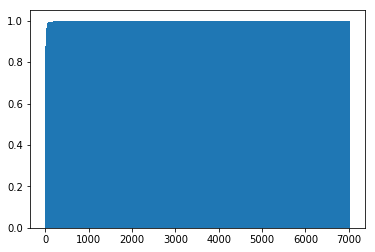

In [25]:
#We don't want to look up every missing address, it will take a while so lets check out a cdf of how many tickets we can get 
print(unfound.shape[0])
plt.hist(unfound['total_tickets'], normed = 1, cumulative = True, bins = 1000)
;

In [26]:
#Extremely steep, lets look up the top 500
#Check to make sure the location returned is valid
def check_location(location):
    if location.latitude > 35 and location.latitude < 39 and location.longitude > -123 and location.longitude < -120:
        return True
    else:
        return False

#Attempt to reverge geocode using OpenStreetMap, 
from geopy.extra.rate_limiter import RateLimiter
geolocator = Nominatim(user_agent = 'SF_Parking_EDA')

def create_locs(address):
    try:
        location = geolocator.geocode(address, timeout = 10)
    except:
        location = None
    time.sleep(1)

    if location != None and check_location(location):
        return (location.latitude, location.longitude )   
    else:
        return None


#return an estimated address, lookup top 500
tqdm.pandas()
unfound['street'] = unfound.apply(lambda x: return_streetname_unknown(x['TickStreetNo'], x['TickStreetName']), axis = 1)
#combine into an address
unfound['address'] = unfound.apply(lambda x: str(x['TickStreetNo']) + " " + str(x['street']), axis = 1)
lookup = unfound.sort_values(by = 'total_tickets', ascending = False)[:500]
lookup['coordinates'] = lookup['address'].progress_apply(lambda x: create_locs(x + ' SAN FRANCISCO CA'))

100%|██████████| 500/500 [15:00<00:00,  1.82s/it]


In [27]:
lookup.head()

,TickStreetNo,TickStreetName,total_tickets,address,street,coordinates
0,-1,None,7020,-1,,None
4716,-1,MISSION,6556,-1 MISSION ST,MISSION ST,"(37.7932361, -122.3928913)"
4436,-1,MARKET,6371,-1 MARKET ST,MARKET ST,"(37.79407, -122.3949185)"
7003,-1,VAN NESS,5562,-1 VAN NESS,VAN NESS,None
2789,-1,GEARY,4340,-1 GEARY ST,GEARY ST,"(37.787819, -122.4061608)"


In [28]:
# turn everything we looked up into a usable df, append to other data
lookup.dropna(subset = ['coordinates'], inplace = True)
lookup['lat'] = lookup['coordinates'].apply(lambda x: x[0])
lookup['lon'] = lookup['coordinates'].apply(lambda x: x[1])
lookup.rename(columns = {'TickStreetNo':'number', 'TickStreetName':'streetname'}, inplace = True)
lookup = lookup[['lat', 'lon', 'street', 'number', 'streetname', 'address']]


In [29]:
#filter on everything we couldn't find, we'll insert it without any coordinates anyway
unfound = unfound[unfound['address'].isin(lookup['address']) == False]
unfound['type'] = 'unfound'


lookup['type'] = 'searched'
lookup.to_sql('raw_address_data', if_exists = 'append', con = conn)

In [30]:
addresses = result_query('Select * from raw_address_data')
print('addreses' + str(addresses.shape))

addreses(393909, 8)


In [ ]:
#We're going to look up all addresses and associate a neighborhood with them, we'll use this later on
from shapely.geometry import Point
#create a point for each address
addresses['geometry'] = addresses.apply(lambda x: Point(x['lon'], x['lat']), axis = 1)
point = gpd.GeoDataFrame(addresses['geometry'])
point.crs = {'init': 'epsg:4326'}

#load neighborhoods file
poly  = gpd.GeoDataFrame.from_file(raw_folder + 'AnalysisNeighborhoods.geojson')

#join each point into a neighborhood
from geopandas.tools import sjoin
pointInPolys = sjoin(point, poly, how='left')

#convert to string so we can merge back
addresses['geometry'] = addresses['geometry'].astype(str)
pointInPolys['geometry'] = pointInPolys['geometry'].astype(str)

#drop duplicates and put in sql
addresses = addresses.merge(pointInPolys, left_on = 'geometry', right_on = 'geometry')
addresses.drop(columns = ['geometry', 'index', 'index_right'], inplace = True)
addresses.drop_duplicates(subset = 'address', inplace = True)
addresses['number'] = addresses['number'].astype(int)
addresses.to_sql('address_data', conn, if_exists = 'replace')
print('addreses' + str(addresses.shape))

In [ ]:
#add all other addresses that didn't have coordinates
unfound.rename(columns = {'TickStreetNo':'number', 'TickStreetName': 'streetname'}, inplace = True)
unfound.drop(columns = 'total_tickets', inplace = True)
unfound['number'] = unfound['number'].astype(int)
unfound.to_sql('address_data', if_exists = 'append', con = conn)
print('unfound' + str(unfound.shape))

The ticket data doesnt include the street suffix, so sometimes we may not know which street its located on. lets see some of our problem streets. 

In [ ]:
#Now we'll find out which only have one matching street suffix
grouped = addresses.groupby(by = ['number', 'streetname'], as_index = False)['address'].agg('count')
grouped.sort_values(by = 'address', ascending = False) 
grouped.columns = ['number', 'streetname', 'count_ad']

In [ ]:
#We're going to split all single and double addresses. This will help when looking up addresses later
single_address = grouped[grouped.count_ad ==1]
single_address = single_address.merge(addresses, left_on = ['number', 'streetname'], right_on = ['number', 'streetname'])
single_address.to_sql('single_address', conn, if_exists = 'replace')
double_address = addresses[addresses.address.isin(single_address['address']) == False]

print(single_address.shape)
print(double_address.shape)

# Process Raw Ticket Data

We're going to take our raw data and put it in usable form. 

For any address that could have two locations we're going to have to look up other tickets that were given by that officer in that time period, and then sort our best choice based on proximity. 


In [ ]:
def bernoulli(p):
    if np.random.random() < p:
        return 0
    else:
        return 1

nhoodtype = result_query('Select nhood, violationdesc, count(*) tickets from raw_ticket_data t1 join single_address t2 '
                         ' on t1.TickStreetNo = t2.number and t1.TickStreetName = t2.streetname group by nhood, violationdesc')

def return_time(time):
    if time == None:
        time = [0,0]
    else:
        time = time.split(":")
    if len(time) < 2:
        time = [0,0]
    return dt.timedelta(hours = int(time[0]), minutes = int(time[1]))
def return_address(row):
    #For anything we can find using our merges, we use a ratio of total tickets for that violation description and neighborhood
    streetnum = row['TickStreetNo']
    streetname = row['TickStreetName']
    ticket_type = row['ViolationDesc']
    df = double_address[(double_address.number == streetnum) & (double_address.streetname == streetname)]  
    if df.shape[0] > 1:
        if len(re.findall('\d+', streetname)) > 0:

            if ticket_type == 'RES/OT' and int(re.findall('\d+', streetname)[0]) > 15 and (streetnum < 2200 or streetnum > 2600):
                df_st = df[df.street.str.contains("ST")]
                if df_st.shape[0] == 1:
                    return str(int(streetnum)) + " " + df_st['street'].iloc[0]

            if ticket_type == 'RES/OT' and int(re.findall('\d+', streetname)[0]) > 21:
                df_st = df[df.street.str.contains("ST")]
                if df_st.shape[0] == 1:
                    return str(int(streetnum)) + " " + df_st['street'].iloc[0]
            
        df['ViolationDesc'] = ticket_type
        
        df_2 = df.merge(nhoodtype, left_on = ['nhood', 'ViolationDesc'], right_on = ['nhood', 'ViolationDesc'])
        
        if df_2.shape[0] > 0:
            totalcounts = df_2['tickets'].sum()
            topcount = df_2['tickets'].iloc[0]
            topchoice = bernoulli(float(topcount / totalcounts))   
            return str(int(streetnum)) + " " + df_2['street'].iloc[topchoice]

        totalcounts = addresses[addresses.streetname == streetname].shape[0]
        topcount = addresses[addresses.streetname == streetname]['street'].value_counts().iloc[0]
        topchoice = bernoulli(float(topcount / totalcounts))   
        return str(int(streetnum)) + " " + df['street'].iloc[topchoice]



In [ ]:
#add time to date
def Time(row):
    try:
        timeadd = dt.datetime.strptime(row['TickIssueTime'], '%H:%M').time()
    except:
        timeadd = dt.datetime.strptime('00:00', '%H:%M').time()
        
    newtime = dt.datetime.combine(dt.datetime.strptime(row['TickIssueDate'], '%Y-%m-%d %H:%M:%S') , timeadd)
    return newtime

In [ ]:
c = conn.cursor()
c.execute('Select Count(*) from raw_ticket_data')
totalleft = c.fetchone()[0]
print('{} total rows required'.format(totalleft))
np.random.seed(1)

We're going to loop through all raw ticket records, process them in chunks, and insert them into a processed table. 

In [ ]:
df_total = result_query('Select Ticketnumber, TickIssueDate, TickIssueTime, ViolationDesc, '
                  ' VehMake, TickRPPlate, TickStreetNo, TickMeter, Agency, TickBadgeIssued, '
                   'TickStreetName , TotalPaid, TotalAmtDue from raw_ticket_data ')
columnlist = df_total.columns.tolist()
df_total.sort_values(by = 'TickIssueDate', inplace = True)

In [ ]:
def return_time_delta(time):
    if time == None:
        time = [0,0]
    else:
        time = time.split(":")
    if len(time) < 2:
        time = [0,0]
    return dt.timedelta(hours = int(time[0]), minutes = int(time[1]))

In [ ]:
def return_cost(coststring):
    coststring = re.sub('[^1-9]', '', str(coststring))
    try:
        intreturn = int(coststring)
    except:
        intreturn = 0
        
    return intreturn

In [ ]:
#Make a chunk to process, process main columns, and create a timedelta column for the ticket time
df = df_total[0:10000]
df['TickStreetNo'] = df['TickStreetNo'].apply(return_num)
df['ViolationDesc'] = df['ViolationDesc'].apply(lambda x: x.replace('METER DTN','MTR OUT DT'))
df['TickStreetName'] = df['TickStreetName'].apply(replace_street)
df['TotalPaid'] = df['TotalPaid'].apply(lambda x: re.sub('[^1-9]', '', str(x)))
df['TotalAmtDue'] = df['TotalAmtDue'].apply(lambda x: re.sub('[^1-9]', '', str(x)))
df['TickRPPlate'] = df['TickRPPlate'].apply(lambda x: 'None' if len(re.findall('[\w+]', str(x))) == 0 else str(x).replace('[^\w+]', ''))
df['Tdelt'] = df['TickIssueTime'].apply(return_time_delta)

In [ ]:
#Split out what we know and what we'll have to run a merge on 
df_1 = df.merge(single_address, how = 'left',  left_on = ['TickStreetNo', 'TickStreetName'], right_on = ['number', 'streetname'])

In [ ]:
df_1[pd.isnull(df_1.number)][['TickStreetName', 'TickStreetNo']]

In [ ]:
#only include that which will return an address   
df_2 = df.merge(double_address, left_on = ['TickStreetNo', 'TickStreetName'], right_on = ['number', 'streetname']) 

In [ ]:
df_2

In [ ]:
#Merge on badge and neighborhood, sort by time, take top record, anything we cant merge on we'll pass to our function   
df_2 = df_2.merge(df_1, how = 'left', left_on = ['TickIssueDate', 'TickBadgeIssued', 'nhood'], right_on = ['TickIssueDate', 'TickBadgeIssued', 'nhood'])
df_3 = df_2[pd.isnull(df_2['Tdelt_y'])]
df_2.dropna(subset = ['Tdelt_y'], inplace = True)
df_2['timedelta'] = df_2.apply(lambda x: np.abs(x['Tdelt_y'] - x['Tdelt_x']), axis = 1)
df_2.sort_values(by = 'timedelta', inplace = True)

#Replace the columns t
df_2.columns = [col.replace('_x', '') for col in df_2.columns]
df_3.columns = [col.replace('_x', '') for col in df_3.columns]
df_2.drop_duplicates(subset = 'TicketNumber', inplace = True)
df_3['address'] = df_3.progress_apply(return_address, axis = 1)



#append both single and merged records
df = df_1.append(df_2)
df['TickIssueDate'] = df.apply(Time, axis = 1)
df = df[columnlist]

In [ ]:
#Lets loop through entire dataframe and do all of them
import warnings
warnings.filterwarnings('ignore')
n = 500000  #chunk row size
totalsize = df_total.shape[0]
indexes = [i for i in range(0,totalsize, n)]
columnlist = df_total.columns.tolist()
columnlist.append('address')
tqdm.pandas()
j = 1
for i in indexes:
    df = df_total[i:i+n]
    print('Iteration {} started at {}. {} records left'.format(j, dt.datetime.now(), totalsize))   
    df['TickStreetNo'] = df['TickStreetNo'].apply(return_num)
    df['ViolationDesc'] = df['ViolationDesc'].apply(lambda x: x.replace('METER DTN','MTR OUT DT'))
    df['TickStreetName'] = df['TickStreetName'].apply(replace_street)
    df['TickStreetName'] = df['TickStreetName'].apply(return_street)
    df['TotalPaid'] = df['TotalPaid'].apply(return_cost)
    df['TotalAmtDue'] = df['TotalAmtDue'].apply(lambda x: re.sub('[^1-9]', '', str(x)))
    df['TickRPPlate'] = df['TickRPPlate'].apply(lambda x: 'None' if len(re.findall('[\w+]', str(x))) == 0 else str(x).replace('[^\w+]', ''))
    df['Tdelt'] = df['TickIssueTime'].apply(return_time_delta)
    
    
    #Split out what we know and what we'll have to run a function on
    df_1 = df.merge(single_address, left_on = ['TickStreetNo', 'TickStreetName'], right_on = ['number', 'streetname'])
    df_2 = df.merge(double_address, left_on = ['TickStreetNo', 'TickStreetName'], right_on = ['number', 'streetname'])  

    #Merge on badge and neighborhood, sort by time, take top record, anyhting we cant merge on we'll pas to our function   
    df_2 = df_2.merge(df_1, how = 'left', left_on = ['TickIssueDate', 'TickBadgeIssued', 'nhood'], right_on = ['TickIssueDate', 'TickBadgeIssued', 'nhood'])
    df_3 = df_2[pd.isnull(df_2['Tdelt_y'])]
    df_2.dropna(subset = ['Tdelt_y'], inplace = True)
    df_2['timedelta'] = df_2.apply(lambda x: np.abs(x['Tdelt_y'] - x['Tdelt_x']), axis = 1)
    df_2.sort_values(by = 'timedelta', inplace = True)
    
    #Replace the columns t
    df_2.columns = [col.replace('_x', '') for col in df_2.columns]
    df_3.columns = [col.replace('_x', '') for col in df_3.columns]
    df_2.drop_duplicates(subset = 'TicketNumber', inplace = True)
    df_3['address'] = df_3.progress_apply(return_address, axis = 1)
    
    df = df_1.append(df_2)
    df = df.append(df_3)
    df['TickIssueDate'] = df.apply(Time, axis = 1)
    df = df[columnlist]    
                                                                                
    if i == 0:
        df.to_sql('ticket_data', if_exists = 'replace',con = conn)
    else:
        df.to_sql('ticket_data', if_exists = 'append',con = conn)
        
    totalsize -= n
    j+=1
    
print('Finished!')